In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import xtrack as xt
from leapfrog import *

## Toy problem: time-dependent Hamiltonian system

In [3]:
torch.set_default_dtype(torch.float64)

In [4]:
# Parameters
mu = 0.249 * 2.0 * torch.pi  # rotation frequency
k3 = 0.4                     # octupole strength
period = 1.0                 # period of the system
s0 = 0.5                     # position of the perturbation

def hamiltonian_fn(q, p, s):
    H = mu / 2.0 * (q**2 + p**2) + k3 / 4.0 * torch.exp(-1000 * (s % period - s0)**2) * q**4
    return H

def q_prime(q, p, s):
    return mu * p

def p_prime(q, p, s):
    return -mu * q - k3 * torch.exp(-1000 * (s % period - s0)**2) * q**3

In [5]:
hamiltonian = Hamiltonian(hamiltonian_fn, q_prime, p_prime)
integrator = Leapfrog(hamiltonian, step_size=0.01)

In [6]:
steps = 200000
n_particles = 20

q = torch.zeros(n_particles, steps+1)
p = torch.zeros(n_particles, steps+1)

q[:, 0] = torch.linspace(0, 0.7, n_particles)
p[:, 0] = torch.zeros(n_particles)
for i in range(steps):
    q[:, i+1], p[:, i+1] = integrator.step(q[:, i], p[:, i], s=torch.tensor([i*integrator.step_size]))

Text(0, 0.5, 'p')

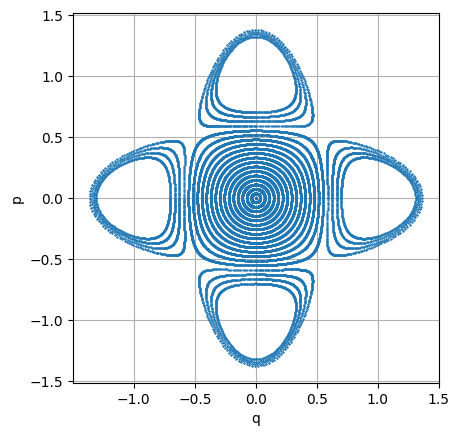

In [7]:
plt.plot(q.numpy()[:, ::100], p.numpy()[:, ::100], '.', markersize=1, color='C0')
plt.gca().set_aspect('equal')
plt.grid()
plt.xlabel('q')
plt.ylabel('p')

PDE given by continuity equation (Liouville's theorem) for the phase space density $\rho$:
$$
  \frac{\partial \rho}{\partial t} + \{H, \rho\} = 0.
$$

# Particle tracking simulations

In [8]:
# load SPS sequence
line = xt.Line.from_json('sequence/sps_ft_q26.json')
line.build_tracker()

Loading line from dict:   0%|          | 0/18751 [00:00<?, ?it/s]

Done loading line from dict.           


In [9]:
# match tunes
line.match(
            method='4d',
            vary=[
                xt.VaryList(['kqf'], step=1e-8, tag='quad'),
                xt.VaryList(['kqd'], step=1e-8, tag='quad'),
            ],
            targets = [
                xt.TargetSet(qx=26.249, tol=1e-6, tag='tune'),
                xt.TargetSet(qy=26.578, tol=1e-6, tag='tune'),
            ])

                                             
Optimize - start penalty: 3.699                             
Matching: model call n. 9 penalty = 5.9895e-09              
Optimize - end penalty:  5.98952e-09                            


In [10]:
# set strength of octupolar perturbation
line['loe.10402'].k3 = 0.2

In [11]:
# track particles
particles = line.build_particles(x=np.linspace(0, 0.01, 20))
line.track(particles, num_turns=2000, turn_by_turn_monitor=True, freeze_longitudinal=True)
record = line.record_last_track

Text(0, 0.5, '$p_x$')

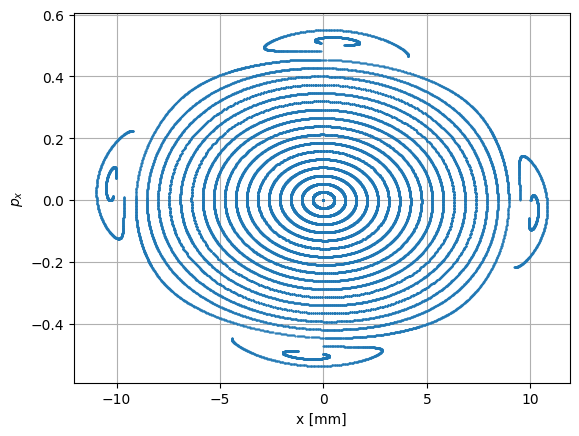

In [12]:
plt.plot(record.x[:, :] * 1000, record.px[:, :] * 1000, '.', markersize=1, color='C0')
plt.grid()
plt.xlabel('x [mm]')
plt.ylabel(r'$p_x$')

In [13]:
import pickle

# Read a pickle file
with open('data_simple_line_2D.pkl', 'rb') as f:
    data = pickle.load(f)

print(type(data['x']))


<class 'numpy.ndarray'>


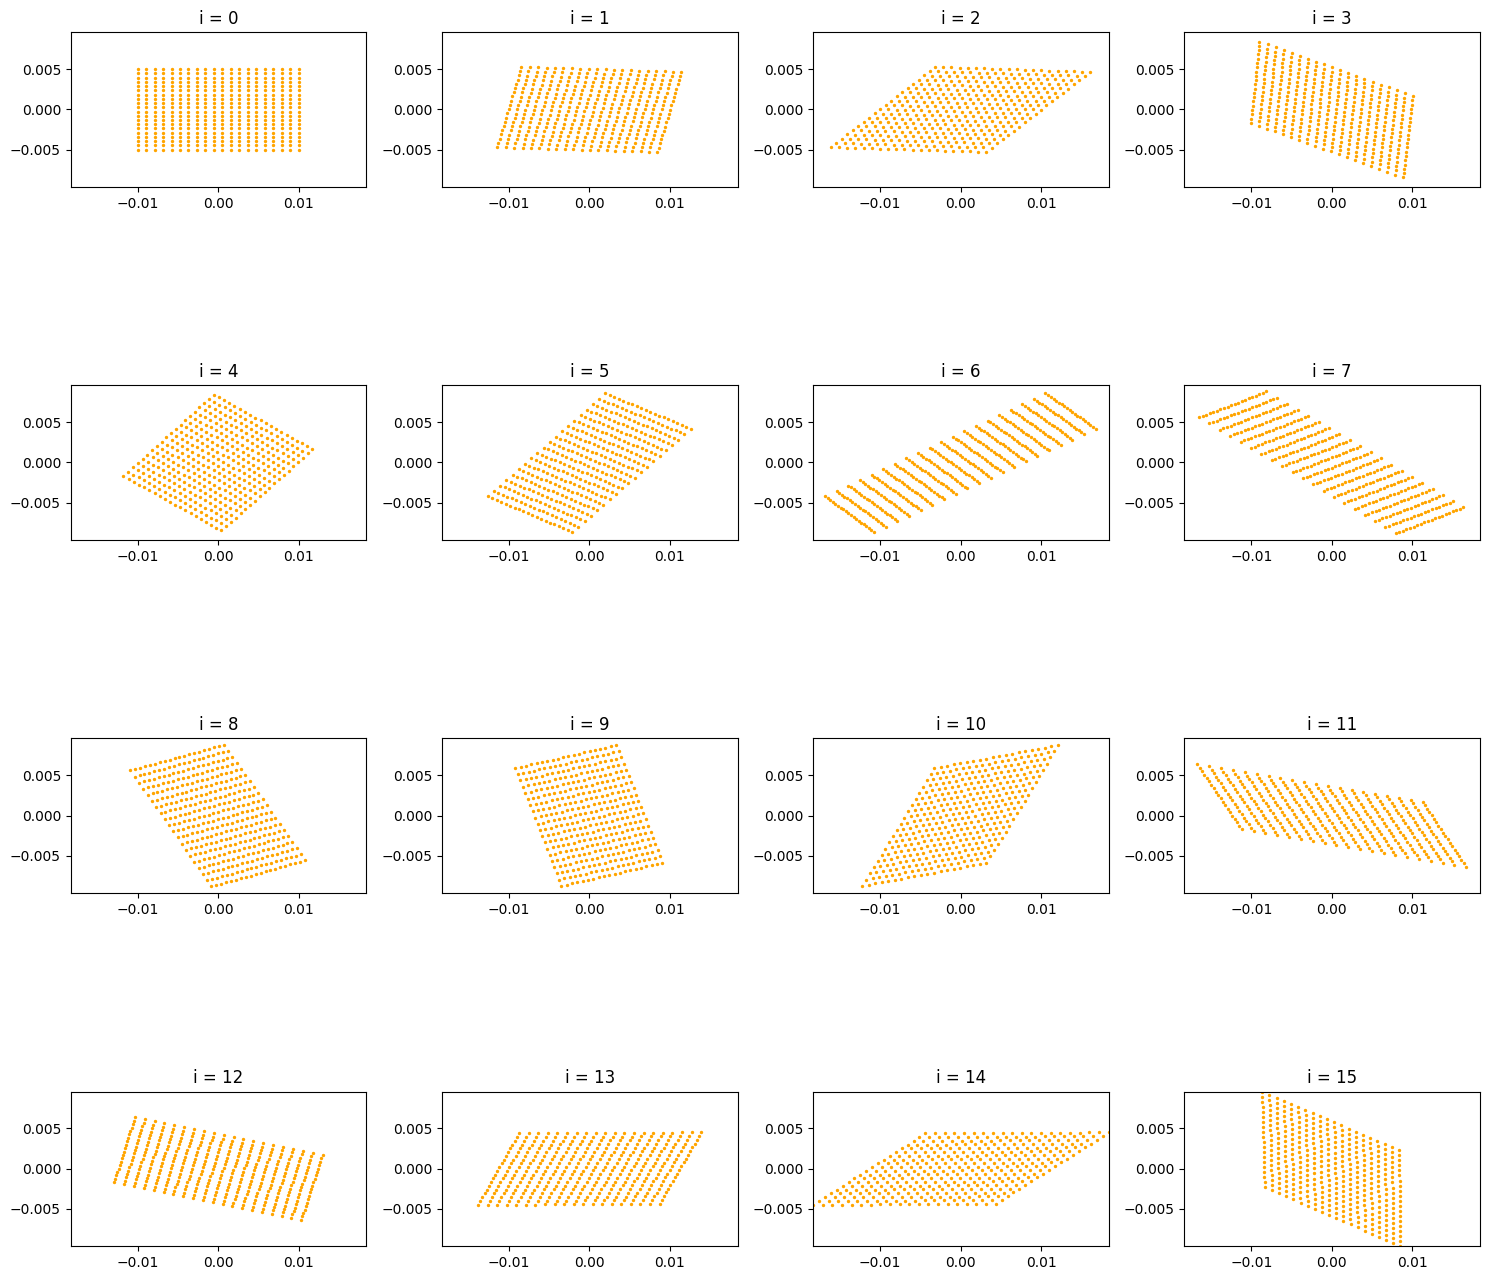

In [36]:
train_data_x = data['x'][:400,:]
train_data_px = data['px'][:400,:]


fig, axes = plt.subplots(4, 4, figsize=(15, 15))

# Find global min/max for consistent scaling
x_min = data['x'].min()
x_max = data['x'].max()
y_min = data['px'].min()
y_max = data['px'].max()

for i in range(16):
    row = i // 4
    col = i % 4
    
    x_data = data['x'][:, i]
    y_data = data['px'][:, i]
    
    axes[row, col].scatter(x_data, y_data, color='orange', s=2)
    axes[row, col].set_xlim(x_min, x_max)
    axes[row, col].set_ylim(y_min, y_max)
    axes[row, col].set_aspect('equal')
    axes[row, col].set_title(f'i = {i}')

plt.tight_layout()
plt.show()

Creating generic accelerator data...
Initializing Symplectic FNO AcceleratorNet...
Model parameters: 1,738,498
Training on device: cpu
Analyzing original data symplectic properties...


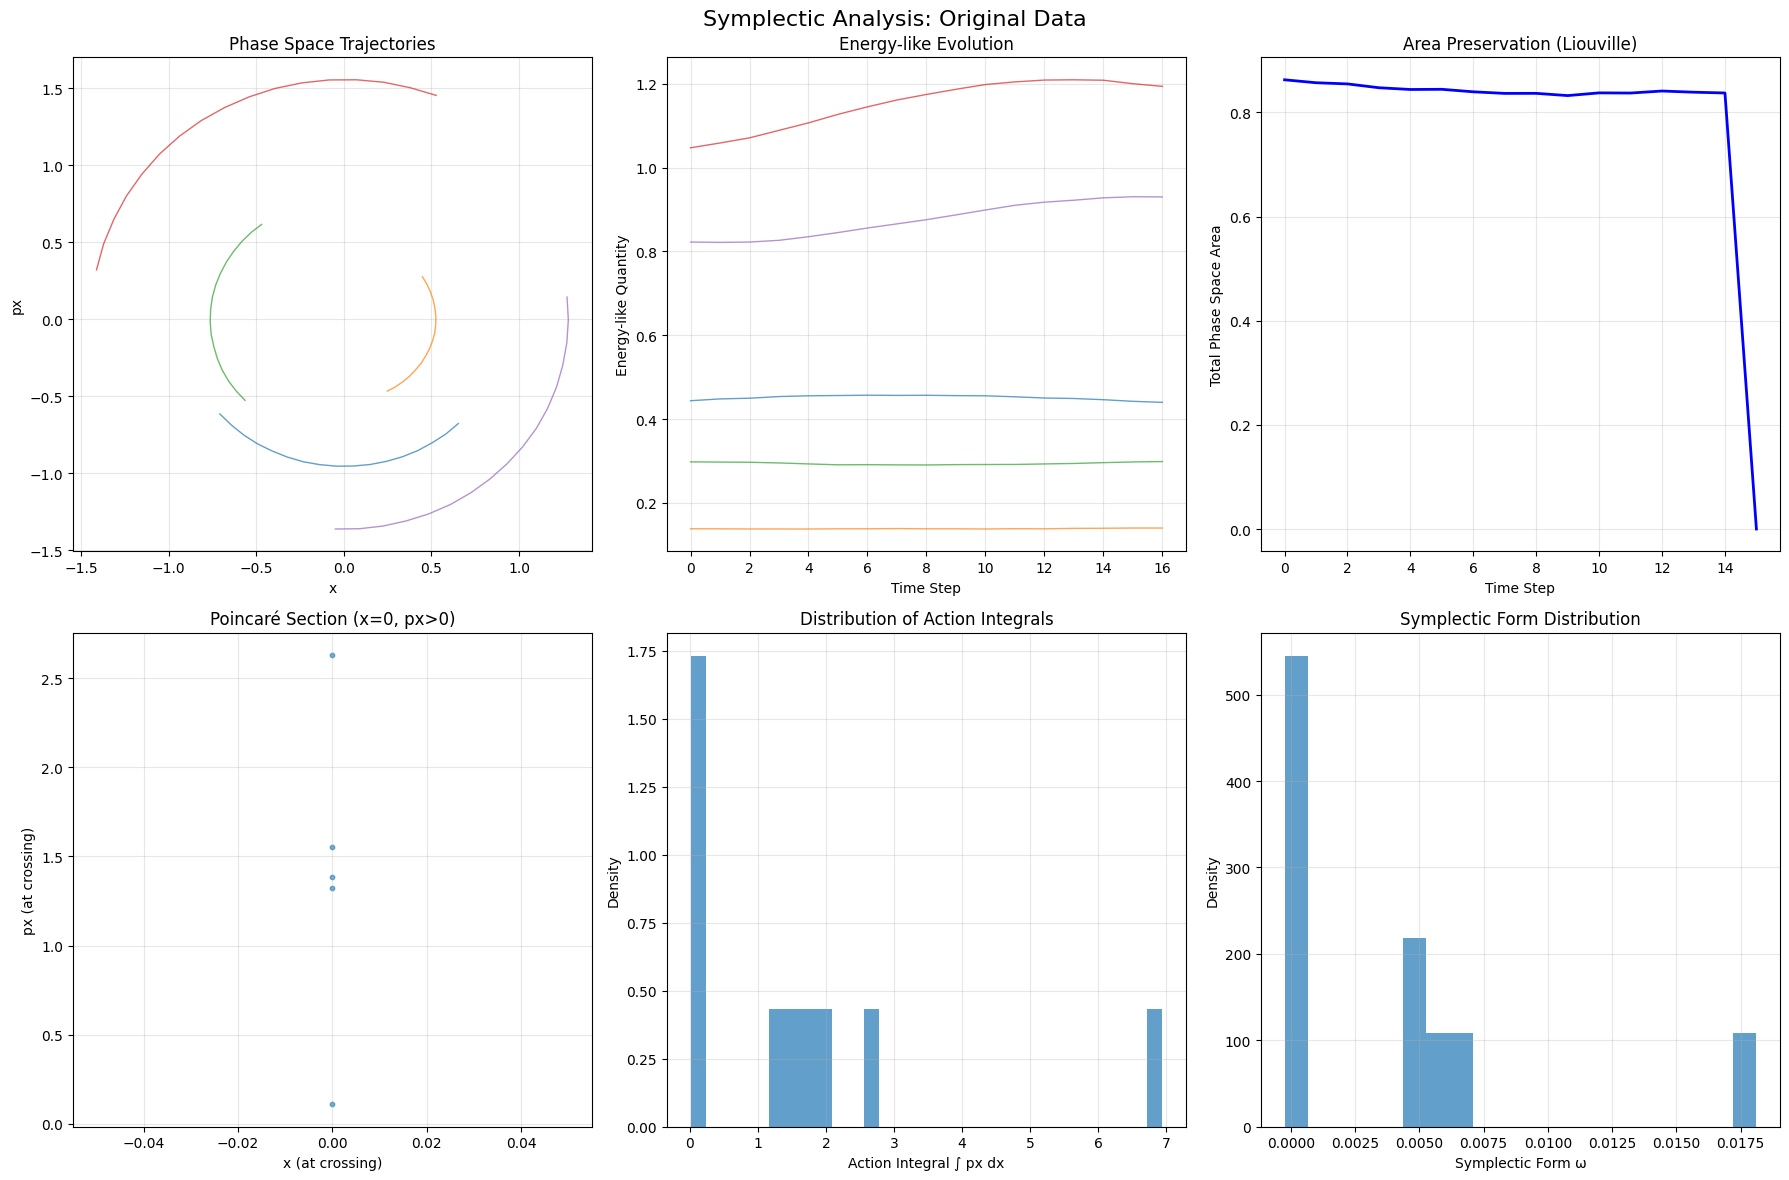

Starting symplectic training...


RuntimeError: Number of dimensions of repeat dims can not be smaller than number of dimensions of tensor

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from typing import Tuple, Optional

class AcceleratorDataset(Dataset):
    """Dataset for particle accelerator trajectory data."""
    
    def __init__(self, data: dict):
        """
        Initialize dataset with particle trajectory data.
        
        Args:
            data: Dictionary containing 'x' and 'px' arrays of shape [n_particles, n_steps]
        """
        # Full trajectories - ensure float32
        self.trajectories = torch.stack([
            torch.tensor(data['x'], dtype=torch.float32),
            torch.tensor(data['px'], dtype=torch.float32)  
        ], dim=1)  # Shape: [N_samples, 2, n_steps]
        
        self.n_steps = data['x'].shape[1]
        
    def __len__(self):
        return len(self.trajectories)
    
    def __getitem__(self, idx):
        # Return the full trajectory - no separate initial conditions needed
        return self.trajectories[idx]

class SpectralConv1d(nn.Module):
    """1D Spectral Convolution Layer for FNO."""
    
    def __init__(self, in_channels: int, out_channels: int, modes: int):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes
        
        # Complex Fourier weights
        scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(
            scale * torch.randn(in_channels, out_channels, modes, dtype=torch.cfloat)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through spectral convolution."""
        batch_size, channels, length = x.shape
        
        # Compute FFT and ensure consistent dtype
        x_ft = torch.fft.rfft(x, dim=-1)
        
        # Ensure x_ft has the same dtype as weights
        if x_ft.dtype != self.weights.dtype:
            x_ft = x_ft.to(self.weights.dtype)
        
        # Initialize output in Fourier space with consistent dtype
        out_ft = torch.zeros(batch_size, self.out_channels, x_ft.size(-1), 
                           dtype=self.weights.dtype, device=x.device)
        
        # Multiply by weights in Fourier space (only low modes)
        if x_ft.size(-1) >= self.modes:
            out_ft[:, :, :self.modes] = torch.einsum('bix,iox->box', 
                                                   x_ft[:, :, :self.modes], 
                                                   self.weights)
        else:
            out_ft[:, :, :x_ft.size(-1)] = torch.einsum('bix,iox->box',
                                                       x_ft[:, :, :x_ft.size(-1)],
                                                       self.weights[:, :, :x_ft.size(-1)])
        
        # Inverse FFT
        return torch.fft.irfft(out_ft, n=length, dim=-1)

class FNOBlock(nn.Module):
    """FNO Block with spectral and local convolution."""
    
    def __init__(self, width: int, modes: int):
        super().__init__()
        self.conv = SpectralConv1d(width, width, modes)
        self.w = nn.Conv1d(width, width, 1)
        self.activation = nn.GELU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.activation(self.conv(x) + self.w(x))

class FNOAcceleratorNet(nn.Module):
    """Fourier Neural Operator for Accelerator Physics."""
    
    def __init__(self, 
                 modes: int = 16, 
                 width: int = 128, 
                 n_layers: int = 6,
                 n_steps: int = 17):
        super().__init__()
        self.modes = modes
        self.width = width
        self.n_layers = n_layers
        self.n_steps = n_steps
        
        # Lift input trajectories to higher dimensional space
        # Input is [x, px] at each time step
        self.fc0 = nn.Linear(2, width)
        
        # FNO layers
        self.fno_blocks = nn.ModuleList([
            FNOBlock(width, modes) for _ in range(n_layers)
        ])
        
        # Project to output space
        self.fc1 = nn.Linear(width, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)  # Output [x, px]
        
        self.dropout = nn.Dropout(0.1)
        
        # Initialize weights properly
        self._initialize_weights()
        
    def _initialize_weights(self):
        """Initialize network weights using Xavier initialization."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        
    def forward(self, trajectories: torch.Tensor) -> torch.Tensor:
        """
        Process particle trajectories through FNO.
        
        Args:
            trajectories: [batch_size, 2, n_steps] - [x, px] trajectories over time
            
        Returns:
            processed_trajectories: [batch_size, 2, n_steps] - processed [x, px] over time
        """
        batch_size, n_vars, n_steps = trajectories.shape
        
        # Permute to [B, n_steps, n_vars] for processing
        x = trajectories.permute(0, 2, 1)  # [B, n_steps, 2]
        
        # Lift to higher dimension
        x = self.fc0(x)  # [B, n_steps, width]
        x = x.permute(0, 2, 1)  # [B, width, n_steps]
        
        # Apply FNO blocks
        for block in self.fno_blocks:
            x = block(x)
        
        # Project to output
        x = x.permute(0, 2, 1)  # [B, n_steps, width]
        x = F.gelu(self.fc1(x))
        x = self.dropout(x)
        x = F.gelu(self.fc2(x))
        x = self.fc3(x)  # [B, n_steps, 2]
        
        # Convert back to [B, 2, n_steps] format
        output = x.permute(0, 2, 1)  # [B, 2, n_steps]
        
        return output
        
    def forward(self, initial_conditions: torch.Tensor) -> torch.Tensor:
        """
        Predict particle trajectories from initial conditions.
        
        Args:
            initial_conditions: [batch_size, 2] - initial [x, px]
            
        Returns:
            trajectories: [batch_size, 2, n_steps] - predicted [x, px] over time
        """
        batch_size = initial_conditions.size(0)
        
        # Create time grid and expand initial conditions
        time_grid = torch.linspace(0, 1, self.n_steps, device=initial_conditions.device, dtype=initial_conditions.dtype)
        
        # Start with initial conditions at each time step
        x = initial_conditions.unsqueeze(-1).repeat(1, 1, self.n_steps)  # [B, 2, n_steps]
        
        # Add time encoding as additional channel
        time_encoding = time_grid.unsqueeze(0).unsqueeze(0).repeat(batch_size, 1, 1)
        x = torch.cat([x, time_encoding], dim=1)  # [B, 3, n_steps]
        
        # Lift to higher dimension - process each time step
        x = x.permute(0, 2, 1)  # [B, n_steps, 3]
        x = self.fc0(x[:, :, :2])  # Only use x, px for lifting, ignore time for now
        x = x.permute(0, 2, 1)  # [B, width, n_steps]
        
        # Apply FNO blocks
        for block in self.fno_blocks:
            x = block(x)
        
        # Project to output
        x = x.permute(0, 2, 1)  # [B, n_steps, width]
        x = F.gelu(self.fc1(x))
        x = self.dropout(x)
        x = F.gelu(self.fc2(x))
        x = self.fc3(x)  # [B, n_steps, 2]
        
        # Ensure initial conditions are preserved
        output = x.permute(0, 2, 1)  # [B, 2, n_steps]
        
        # Force the first time step to match initial conditions exactly
        output[:, :, 0] = initial_conditions
        
        return output

class SymplecticFNO(FNOAcceleratorNet):
    """Symplectic FNO that preserves phase space structure without Hamiltonian assumptions."""
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def symplectic_form_loss(self, trajectories: torch.Tensor) -> torch.Tensor:
        """
        Enforce preservation of symplectic 2-form ω = dx ∧ dpx.
        
        The symplectic form should be preserved: ω(v₁, v₂) = ω(Φ*v₁, Φ*v₂)
        where Φ is the flow map and v₁, v₂ are tangent vectors.
        
        Args:
            trajectories: [batch_size, 2, n_steps] - [x, px] trajectories
            
        Returns:
            Symplectic form preservation loss
        """
        batch_size, n_vars, n_steps = trajectories.shape
        
        if n_steps < 3:
            return torch.tensor(0.0, device=trajectories.device, dtype=trajectories.dtype)
        
        x, px = trajectories[:, 0, :], trajectories[:, 1, :]  # [batch_size, n_steps]
        
        # Compute finite difference approximations of derivatives
        dt = torch.tensor(1.0, device=trajectories.device, dtype=trajectories.dtype)
        
        # Forward differences for first step
        dx_dt_0 = (x[:, 1] - x[:, 0]) / dt  # [batch_size]
        dpx_dt_0 = (px[:, 1] - px[:, 0]) / dt  # [batch_size]
        
        # Central differences for middle steps
        dx_dt_mid = (x[:, 2:] - x[:, :-2]) / (2 * dt)  # [batch_size, n_steps-2]
        dpx_dt_mid = (px[:, 2:] - px[:, :-2]) / (2 * dt)  # [batch_size, n_steps-2]
        
        # Backward differences for last step
        dx_dt_end = (x[:, -1] - x[:, -2]) / dt  # [batch_size]
        dpx_dt_end = (px[:, -1] - px[:, -2]) / dt  # [batch_size]
        
        # Concatenate all derivatives - fix dimension issues
        dx_dt = torch.cat([
            dx_dt_0.unsqueeze(1),  # [batch_size, 1]
            dx_dt_mid,             # [batch_size, n_steps-2]  
            dx_dt_end.unsqueeze(1) # [batch_size, 1]
        ], dim=1)  # [batch_size, n_steps]
        
        dpx_dt = torch.cat([
            dpx_dt_0.unsqueeze(1),  # [batch_size, 1]
            dpx_dt_mid,             # [batch_size, n_steps-2]
            dpx_dt_end.unsqueeze(1) # [batch_size, 1]
        ], dim=1)  # [batch_size, n_steps]
        
        # Symplectic 2-form preservation: d(x ∧ px) = dx ∧ dpx should be conserved
        # For discrete case: check that area elements are preserved
        symplectic_form = x * dpx_dt - px * dx_dt
        
        # The symplectic form should be constant along trajectories (Liouville's theorem)
        symplectic_variation = torch.var(symplectic_form, dim=1)
        
        return torch.mean(symplectic_variation)

def train_accelerator_fno(model: nn.Module, 
                         train_loader: DataLoader, 
                         val_loader: DataLoader,
                         epochs: int = 100,
                         physics_weight: float = 0.1,
                         device: str = 'cpu') -> dict:
    """
    Train the FNO AcceleratorNet model.
    
    Args:
        model: FNO model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        epochs: Number of training epochs
        physics_weight: Weight for physics-informed losses
        device: Device to train on
        
    Returns:
        Dictionary with training history
    """
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.MSELoss()
    
    history = {'train_loss': [], 'val_loss': [], 'physics_loss': []}
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        physics_loss_total = 0
        
        for initial_cond, trajectories in train_loader:
            initial_cond = initial_cond.to(device)
            trajectories = trajectories.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            pred_trajectories = model(initial_cond)
            
            # Reconstruction loss
            recon_loss = criterion(pred_trajectories, trajectories)
            
            # Physics-informed losses - only for SymplecticFNO
            physics_loss = 0
            if isinstance(model, SymplecticFNO):
                symplectic_loss = model.symplectic_form_loss(pred_trajectories)
                volume_loss = model.volume_preservation_loss(pred_trajectories)
                physics_loss = symplectic_loss + 0.5 * volume_loss
                physics_loss_total += physics_loss.item()
            
            # Total loss
            total_loss = recon_loss + physics_weight * physics_loss
            
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += recon_loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for initial_cond, trajectories in val_loader:
                initial_cond = initial_cond.to(device)
                trajectories = trajectories.to(device)
                
                pred_trajectories = model(initial_cond)
                val_loss += criterion(pred_trajectories, trajectories).item()
        
        scheduler.step()
        
        # Record history
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_physics_loss = physics_loss_total / len(train_loader)
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['physics_loss'].append(avg_physics_loss)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:3d}: Train Loss {avg_train_loss:.6f}, '
                  f'Val Loss {avg_val_loss:.6f}, Physics Loss {avg_physics_loss:.6f}')
    
    return history

def train_symplectic_fno(model: SymplecticFNO, 
                        train_loader: DataLoader, 
                        val_loader: DataLoader,
                        epochs: int = 100,
                        symplectic_weight: float = 0.1,
                        device: str = 'cpu') -> dict:
    """
    Train the Symplectic FNO AcceleratorNet model with symplectic constraints only.
    
    Args:
        model: Symplectic FNO model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        epochs: Number of training epochs
        symplectic_weight: Weight for symplectic form loss
        device: Device to train on
        
    Returns:
        Dictionary with training history
    """
    model = model.to(device)
    # Ensure model is in float32
    model = model.float()
    
    # Use a higher learning rate and different optimizer settings
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.MSELoss()
    
    history = {
        'train_loss': [], 
        'val_loss': [], 
        'symplectic_loss': []
    }
    
    # Warmup phase - train without symplectic loss first
    warmup_epochs = 10
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        symplectic_loss_total = 0
        
        for batch in train_loader:
            # batch is now [batch_size, 2, n_steps] - trajectories
            trajectories = batch.to(device).float()
            
            optimizer.zero_grad()
            
            # Forward pass - process the trajectories
            pred_trajectories = model(trajectories)
            
            # Reconstruction loss
            recon_loss = criterion(pred_trajectories, trajectories)
            
            # Symplectic loss only (after warmup period)
            if epoch >= warmup_epochs:
                symplectic_loss = model.symplectic_form_loss(pred_trajectories)
                total_loss = recon_loss + symplectic_weight * symplectic_loss
                symplectic_loss_total += symplectic_loss.item()
            else:
                # During warmup, only use reconstruction loss
                total_loss = recon_loss
                symplectic_loss_total += 0.0
            
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            # Accumulate losses
            train_loss += recon_loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                # batch is [batch_size, 2, n_steps] - trajectories
                trajectories = batch.to(device).float()
                
                pred_trajectories = model(trajectories)
                val_loss += criterion(pred_trajectories, trajectories).item()
        
        scheduler.step()
        
        # Record history
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(val_loader))
        history['symplectic_loss'].append(symplectic_loss_total / len(train_loader))
        
        if epoch % 10 == 0:
            phase = "Warmup" if epoch < warmup_epochs else "Full"
            print(f'Epoch {epoch:3d} ({phase}): Train Loss {history["train_loss"][-1]:.6f}, '
                  f'Val Loss {history["val_loss"][-1]:.6f}, '
                  f'Symplectic {history["symplectic_loss"][-1]:.6f}')
    
    return history

def visualize_predictions(model: nn.Module, 
                         data: dict, 
                         n_samples: int = 4,
                         device: str = 'cpu'):
    """Visualize model predictions vs ground truth."""
    model.eval()
    
    # Create dataset and sample random trajectories
    dataset = AcceleratorDataset(data)
    indices = np.random.choice(len(dataset), n_samples, replace=False)
    
    fig, axes = plt.subplots(2, n_samples, figsize=(4*n_samples, 8))
    if n_samples == 1:
        axes = axes.reshape(2, 1)
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            true_traj = dataset[idx]
            true_traj_input = true_traj.unsqueeze(0).to(device)
            
            # Predict trajectory
            pred_traj = model(true_traj_input).cpu().squeeze(0)
            
            # Plot x trajectory
            time_steps = range(len(true_traj[0]))
            axes[0, i].plot(time_steps, true_traj[0], 'b-', label='True', linewidth=2)
            axes[0, i].plot(time_steps, pred_traj[0], 'r--', label='Predicted', linewidth=2)
            axes[0, i].set_title(f'Position x - Sample {i+1}')
            axes[0, i].set_xlabel('Time Step')
            axes[0, i].set_ylabel('x')
            axes[0, i].legend()
            axes[0, i].grid(True, alpha=0.3)
            
            # Plot px trajectory  
            axes[1, i].plot(time_steps, true_traj[1], 'b-', label='True', linewidth=2)
            axes[1, i].plot(time_steps, pred_traj[1], 'r--', label='Predicted', linewidth=2)
            axes[1, i].set_title(f'Momentum px - Sample {i+1}')
            axes[1, i].set_xlabel('Time Step')
            axes[1, i].set_ylabel('px')
            axes[1, i].legend()
            axes[1, i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def create_generic_accelerator_data(n_particles: int = 1000, 
                                   n_steps: int = 17,
                                   nonlinear_strength: float = 0.1) -> dict:
    """
    Create generic accelerator data without assuming specific Hamiltonian form.
    Uses a more complex, realistic accelerator-like dynamics.
    
    Args:
        n_particles: Number of particle trajectories
        n_steps: Number of time steps
        nonlinear_strength: Strength of nonlinear effects
        
    Returns:
        Dictionary with 'x' and 'px' trajectory arrays
    """
    # Random initial conditions with realistic accelerator distributions
    x0 = np.random.randn(n_particles) * 1.0  # Initial positions
    px0 = np.random.randn(n_particles) * 0.5  # Initial momenta
    
    # Initialize arrays
    x = np.zeros((n_particles, n_steps))
    px = np.zeros((n_particles, n_steps))
    
    x[:, 0] = x0
    px[:, 0] = px0
    
    dt = 0.1
    
    # Integrate more complex dynamics that preserve symplecticity
    # Using a symplectic integrator (Störmer-Verlet method)
    for t in range(1, n_steps):
        # Generic focusing/defocusing forces (like in accelerators)
        # Linear restoring force
        force_linear = -x[:, t-1]
        
        # Nonlinear corrections (sextupole-like)
        force_nonlinear = -nonlinear_strength * x[:, t-1]**3
        
        # Coupling between transverse planes (realistic in accelerators)
        force_coupling = -0.05 * x[:, t-1] * px[:, t-1]**2
        
        # Total force
        total_force = force_linear + force_nonlinear + force_coupling
        
        # Störmer-Verlet integration (symplectic)
        # First update momentum by half step
        px_half = px[:, t-1] + 0.5 * dt * total_force
        
        # Update position
        x[:, t] = x[:, t-1] + dt * px_half
        
        # Recalculate force at new position
        force_linear_new = -x[:, t]
        force_nonlinear_new = -nonlinear_strength * x[:, t]**3
        force_coupling_new = -0.05 * x[:, t] * px_half**2
        total_force_new = force_linear_new + force_nonlinear_new + force_coupling_new
        
        # Complete momentum update
        px[:, t] = px_half + 0.5 * dt * total_force_new
        
        # Add small amount of noise to simulate measurement errors
        x[:, t] += np.random.randn(n_particles) * 0.001
        px[:, t] += np.random.randn(n_particles) * 0.001
    
    return {'x': x, 'px': px}

def analyze_symplectic_properties(trajectories: torch.Tensor, title: str = ""):
    """
    Analyze and visualize symplectic properties of trajectories.
    
    Args:
        trajectories: [batch_size, 2, n_steps] tensor
        title: Title for plots
    """
    x, px = trajectories[:, 0].detach().cpu().numpy(), trajectories[:, 1].detach().cpu().numpy()
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Symplectic Analysis: {title}', fontsize=16)
    
    # Phase space plots
    for i in range(min(5, x.shape[0])):
        axes[0, 0].plot(x[i], px[i], alpha=0.7, linewidth=1)
    axes[0, 0].set_xlabel('x')
    axes[0, 0].set_ylabel('px')
    axes[0, 0].set_title('Phase Space Trajectories')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Energy-like quantity (px^2/2 + x^2/2) - not assuming this is conserved
    energy_like = px**2/2 + x**2/2
    for i in range(min(5, x.shape[0])):
        axes[0, 1].plot(energy_like[i], alpha=0.7, linewidth=1)
    axes[0, 1].set_xlabel('Time Step')
    axes[0, 1].set_ylabel('Energy-like Quantity')
    axes[0, 1].set_title('Energy-like Evolution')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Area preservation check
    areas = []
    n_steps = x.shape[1]
    for t in range(1, n_steps):
        # Compute area using shoelace formula for each trajectory
        area_t = 0
        for i in range(x.shape[0]):
            if t < n_steps - 1:
                # Triangle area formed by origin and two consecutive points
                area_i = 0.5 * abs(x[i, t] * px[i, t+1] - x[i, t+1] * px[i, t])
                area_t += area_i
        areas.append(area_t)
    
    axes[0, 2].plot(areas, 'b-', linewidth=2)
    axes[0, 2].set_xlabel('Time Step')
    axes[0, 2].set_ylabel('Total Phase Space Area')
    axes[0, 2].set_title('Area Preservation (Liouville)')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Poincaré section (when x crosses zero with positive velocity)
    poincare_x = []
    poincare_px = []
    for i in range(x.shape[0]):
        for t in range(n_steps - 1):
            if x[i, t] * x[i, t+1] < 0 and px[i, t] > 0:  # Zero crossing with positive momentum
                # Linear interpolation to find exact crossing
                alpha = -x[i, t] / (x[i, t+1] - x[i, t])
                px_cross = px[i, t] + alpha * (px[i, t+1] - px[i, t])
                poincare_x.append(0.0)
                poincare_px.append(px_cross)
    
    if poincare_px:
        axes[1, 0].scatter(poincare_x, poincare_px, alpha=0.6, s=10)
        axes[1, 0].set_xlabel('x (at crossing)')
        axes[1, 0].set_ylabel('px (at crossing)')
        axes[1, 0].set_title('Poincaré Section (x=0, px>0)')
        axes[1, 0].grid(True, alpha=0.3)
    
    # Action integral ∫ px dx
    action_integrals = []
    for i in range(x.shape[0]):
        dx = np.diff(x[i])
        px_mid = (px[i, 1:] + px[i, :-1]) / 2
        action = np.sum(px_mid * dx)
        action_integrals.append(action)
    
    axes[1, 1].hist(action_integrals, bins=30, alpha=0.7, density=True)
    axes[1, 1].set_xlabel('Action Integral ∫ px dx')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].set_title('Distribution of Action Integrals')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Symplectic form ω = dx ∧ dpx
    symplectic_forms = []
    for i in range(min(10, x.shape[0])):  # Limit for computational efficiency
        dx = np.diff(x[i])
        dpx = np.diff(px[i])
        # Approximate symplectic 2-form
        omega = np.mean(dx * dpx)  # Simplified version
        symplectic_forms.append(omega)
    
    if symplectic_forms:
        axes[1, 2].hist(symplectic_forms, bins=20, alpha=0.7, density=True)
        axes[1, 2].set_xlabel('Symplectic Form ω')
        axes[1, 2].set_ylabel('Density')
        axes[1, 2].set_title('Symplectic Form Distribution')
        axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Create generic accelerator data without Hamiltonian assumptions
    print("Creating generic accelerator data...")
    data = create_generic_accelerator_data(n_particles=2000, n_steps=17, nonlinear_strength=0.1)
    
    # Create dataset and data loaders
    dataset = AcceleratorDataset(data)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)
    
    # Create symplectic model (no Hamiltonian assumptions)
    print("Initializing Symplectic FNO AcceleratorNet...")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = SymplecticFNO(modes=16, width=128, n_layers=6, n_steps=17)
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Training on device: {device}")
    
    # Analyze original data symplectic properties
    sample_trajectories = torch.tensor(
        np.stack([data['x'][:10], data['px'][:10]], axis=1), 
        dtype=torch.float32
    )
    print("Analyzing original data symplectic properties...")
    analyze_symplectic_properties(sample_trajectories, "Original Data")
    
    # Train model with symplectic constraints
    print("Starting symplectic training...")
    history = train_symplectic_fno(
        model, train_loader, val_loader, 
        epochs=50, symplectic_weight=0.1, device=device
    )
    
    # Visualize results
    print("Visualizing predictions...")
    visualize_predictions(model, data, n_samples=4, device=device)
    
    # Analyze learned symplectic properties
    model.eval()
    with torch.no_grad():
        sample_trajectories = torch.stack([dataset[i] for i in range(10)]).to(device)
        predicted_trajectories = model(sample_trajectories).cpu()
    
    print("Analyzing predicted symplectic properties...")
    analyze_symplectic_properties(predicted_trajectories, "FNO Predictions")
    
    print("Symplectic training completed!")